In [7]:
# libraries used by different members for the report
library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
library(rvest)
library(stringr)
library(janitor)
library(lubridate)
library(GGally)
library(ISLR)

# libraries for visualization
library(ggplot2)
library(dplyr)
library(tidyr)
library(patchwork)

# Title : Predicting  High-Value Players for the creation of a complex AI that can understand speech and react to complex environement using Minecraft 

# Introduction: 

**The research project**
The Pacific Laboratory for Artificial Intelligence (PLAI) at UBC, led by Professor Frank Wood, is trying to build embodied AI agents that can behave like real human players inside Minecraft.

**The question**
We want to know if player's characteristics, like their experience, subscription to the game's newsletter, and gender can predict how long in hours a player would play according to the dataset players?

**Why**
To better grasp human players behaviors to build a believable AI, significant amounts of data is needed. This data is collected through interactions the players will have in the server. So it is crucial for the recruted participants to stay online for longer amounts of time.

3 characteristics of the players were chosen to be able to provide a comprehensive list of what should be prioritised when recruiting efforts. Since all 3 are all self identified, they may provide bias (social desirability in reporting gender, or overstatement of experience, etc).

The demographic of age was not chosen because as seen in the exploration of the data below, most players have similar ages. The high concentration around a single age group doesnt allow for age to have significance when recruiting. The highest and the lowest contibuting player will both most likely be in the same age range.

Only data set players is needed for this question as it has all the information about the demographic. Sessions could be useful to then see players habits but just to answer the question of most data collected, player habits would be too specific.


**The dataset: players**


There are 196 observations over rows for 7 variables in the columns of a tibble:

|**variable**|**data type**|**categories**|**meaning**|
|-|-|-|-|
| experience | character | 5 | skillset of the player: Beginner, Amateur, Regular, Veteran, Pro|
| subscribe | logical | 2 | indicating active subscription status: TRUE (subscribed) or FALSE (not subscribed) |
| hashedEmail | character | 196 | unique identifications |
| played_hours | real number | n/a | time in hours spent on the server by a player |
| name | character | 196 | unique identifications |
| gender | character | 7 | gender of the player : Male, Female, Non-binary, Agender, Two-Spirited, Prefer not to say, Other|
| age | real number | n/a | age of the player |


potential issues:
- gender variable is inclusive but could reduce data accuracy since categories like "Prefer not to say" introduce ambiguity, as they could represent individuals from another gender group
- positively skewed played_hours, majority of values are very close to 0h with a few big outliers (around 200h)
- 3 (experience, gender, age) of the variables are self identified, they may provide bias (social desirability in reporting age or gender, or overstatement of experience, etc).
  - emails and name are self identified as well but are not determining characteristics of players that affect play-time/engagenent. they identify too specifically and dont represent a "type" of player


# Methods & Results:
describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which: 
- loads data wrangles and cleans the data to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis (note: all figures should have a figure number and a legend)

In [8]:
# load the data 
players <- read_csv("https://raw.githubusercontent.com/ctrl-tiramisu/dsci100-group-008/refs/heads/main/players.csv", show_col_types = FALSE)
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


In [9]:
# a summary of the data set relevant for EDA related to the planned analysis

players_relevent_summary <- players |>
  summarise(
    variable = "played_hours",
    mean = mean(played_hours, na.rm = TRUE),
    median = median(played_hours, na.rm = TRUE),
    standard_deviation = sd(played_hours, na.rm = TRUE),
    minimum = min(played_hours, na.rm = TRUE),
    maximum = max(played_hours, na.rm = TRUE))


players_relevent_summary

variable,mean,median,standard_deviation,minimum,maximum
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
played_hours,5.845918,0.1,28.35734,0,223.1


In [10]:
# tidy the data to 100% ensure smooth analysis even if data already appears as tidy
players_tidy <- players|>
    mutate(
        Age = as.numeric(Age),
        subscribe = as.logical(subscribe),
        experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro")), #levels to ensure R does not order alphabeticall but with progressiong
        gender = factor(gender))
players_tidy


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


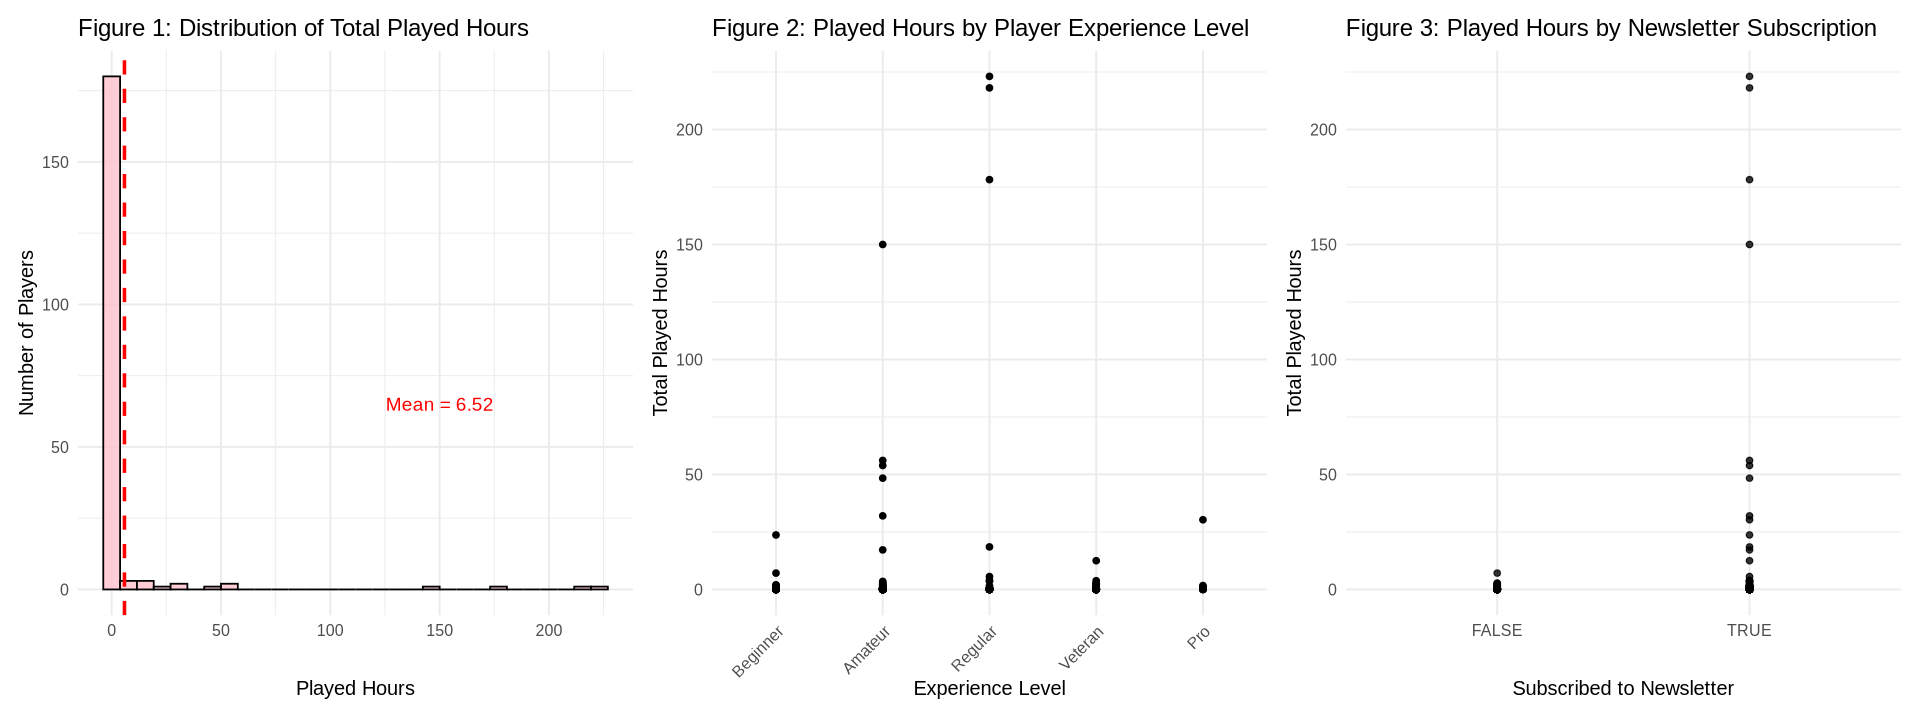

experience,num_players,mean_hours_experience,total_hrs
<fct>,<int>,<dbl>,<dbl>
Beginner,35,1.2485714,43.7
Amateur,63,6.0174603,379.1
Regular,36,18.2083333,655.5
Veteran,48,0.6479167,31.1
Pro,14,2.6000000,36.4


gender,numgender,mean_hrs,tot_hrs
<fct>,<int>,<dbl>,<dbl>
Agender,2,6.25000000,12.5
Female,37,10.63513514,393.5
Male,124,4.12741935,511.8
Non-binary,15,14.88000000,223.2
Other,1,0.20000000,0.2
Prefer not to say,11,0.37272727,4.1
Two-Spirited,6,0.08333333,0.5


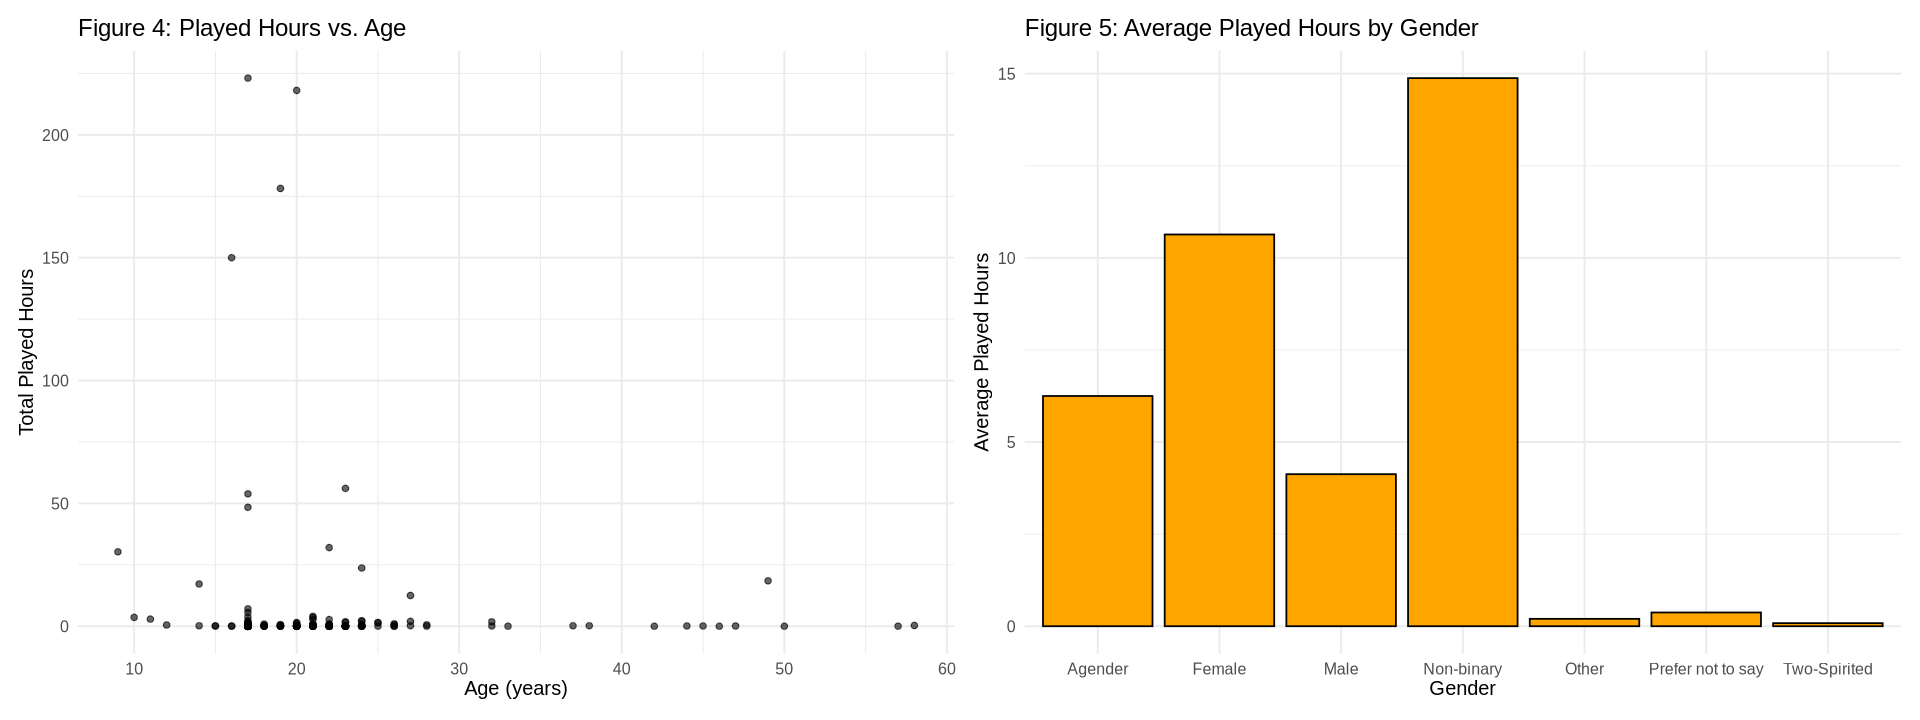

In [16]:
# visualizations of the dataset that is relevant for exploratory data analysis 
# related to the planned analysis
options(repr.plot.width = 16, repr.plot.height = 6)

# Distribution of Total Played Hours
player_distribution <- players_tidy |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(bins = 30, fill = "pink", color = "black", alpha = 0.8) +
    labs(title = "Figure 1: Distribution of Total Played Hours",x = "Played Hours",y = "Number of Players") +
  theme_minimal(base_size = 12) +
  geom_vline(aes(xintercept = mean(played_hours)), 
             color = "red", linetype = "dashed", size = 1) +
  annotate("text", x = 150, y = 65, label = "Mean = 6.52", color = "red", size = 4)


# Played Hours by Player Experience Level
players_experience_hours <- players_tidy |>
  ggplot(aes(x = experience, y = played_hours)) +
  geom_point() +
  labs(title = "Figure 2: Played Hours by Player Experience Level", x = "Experience Level", y = "Total Played Hours") +
  theme_minimal(base_size = 12) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Played Hours by Newsletter Subscription
players_subscribe_hours <- players_tidy |>
  ggplot(aes(x = subscribe, y = played_hours)) +
  geom_point(alpha = 0.8,) +
  labs(title = "Figure 3: Played Hours by Newsletter Subscription", x = "Subscribed to Newsletter", y = "Total Played Hours") +
  theme_minimal(base_size = 12)

# Played Hours vs. Age
players_age_played <- players_tidy |>
  ggplot(aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.6) +
  labs(title = "Figure 4: Played Hours vs. Age", x = "Age (years)", y = "Total Played Hours") +
  theme_minimal(base_size = 12)

# Average Played Hours by Gender
gender_played <- players |>
  group_by(gender) |>
  summarise(mean_hours = mean(played_hours)) |>
  ggplot(aes(x = gender, y = mean_hours)) +
  geom_bar(stat = "identity", fill = "orange", color = "black") +
  labs(title = "Figure 5: Average Played Hours by Gender", x = "Gender", y = "Average Played Hours") +
  theme_minimal(base_size = 12) 

# proportions across gender
num_gender <- players_tidy |>
    group_by(gender) |>
    summarise(numgender = n(), mean_hrs = (mean(played_hours)), tot_hrs= (sum(played_hours)))

# proportions across experience
skillset_counts <- players_tidy |>
  group_by(experience) |>
  summarise(n_players = n()) |>
  mutate(percentage = round(100 * n_players / sum(n_players), 1))|>
  ungroup()

proportion <- players_tidy |> 
    group_by(experience) |>
    summarise(num_players = n(), mean_hours_experience = mean(played_hours), total_hrs = sum(played_hours))

# print out vizualization side by side
(player_distribution + players_experience_hours + players_subscribe_hours)
(players_age_played + gender_played)
proportion
num_gender

# Discussion 
- summarize what you found discuss whether this is what you expected to find discuss what impact could such findings have
- discuss what future questions could this lead to 




# References: 
You may include references if necessary, as long as they all have a consistent citation style.